In [1]:
using DifferentialEquations
using Plots

pyplot()

Plots.PyPlotBackend()

Ниже **явная разностная схема**

Опишу все переменные по порядку:
 - startcond, bordcond задают начальные и граничные условия, почему они так выглядят - хз, но в интернетах пишут, что они выглядт так + ничего о адибатических условиях граничных я не в интернете не нашел
  - D(u) коэффициент теплопроводности, поставил единицу(а почему бы и нет)
   - Nx, Nt задают количество узлов, из них получаем размеры сетки и соответвественно размер коэффициента $\kappa*\frac{\Delta{t}}{\Delta{x}^2}$
   - U массив значений температур в разнух узлах сетки
Теперь графики:
 - Первый график показывает сравнение темеператур в как менялась температура на разно расстоянии в разные моменты времени(1 шаг, 10 шаг, 40 шаг). По оси абсцисс - расстоянии, по оси ординат - температура
  - Второй график показывает по сути распространение тепла, (так и называется *heatmap*)

In [12]:
δ(x) = x==0 ? 0.5 : x>0 ? 1 : 0 # дельта-функция с использованием тернарного оператора
startcond = x-> δ(x - 0.45) - δ(x - 0.55)# начальное условие
bordrcond = x-> 0 # условие на границе
startcond_N = x->1
D(u) = 0.00011613 # коэффициент теплопроводности сосны
τ(n) = 1 # время перераспределения энергии
E = 0.656 # энергия
ΔN(u, n, t) = 0


function linexplicit(Nx = 50, Nt = 40; tlmt = 0.1)
    dx = 1/Nx
    dt = tlmt/Nt
    r = dt/(dx*dx)

    x = [i for i in range(0, length = Nx, step = dx)] 
    t = [i for i in range(0, length = Nt, step = dt)] 
    U = zeros(Nx, Nt)
    N = zeros(Nx, Nt)
    T = zeros(Nx, Nt)
    
    N[:, 1] = startcond_N.(x)

    U[:,1] = startcond.(x)
    U[1,:] = U[Nt,:] = bordrcond.(t)

    for j = 1:Nt-1, i = 2:Nx-1
        U[i, j+1] = U[i,j]*(1-2*r*D( U[i,j] )) + r*U[i-1,j]*D( U[i-1,j] ) + r*U[i+1,j]*D( U[i+1,j]) - ΔN(U[i, j], N[i, j], dt)
        N[i, j+1] = N[i, j] - ΔN(U[i, j], N[i, j], dt)
        T[i, j] = U[1, j] + 0.65*(1/sqrt(4*pi*r*D(U[i, j])*j))*exp(-i^2/(4*r*D(U[i,j])*j))
    end
    t, x, U, N, T
end

t, X, Ans2, N, T = linexplicit( tlmt = 10) # Юхху, время теперь 10 секунд

plot(X, T[:,40], lab="analytical")
plot!(X, Ans2[:,1], lab = "0.4s")
plot!(X, Ans2[:,10], lab = "4s")
p = plot!(X, Ans2[:,40], lab = "10s", title = "Явная разностная схема")
plot( p, heatmap(t, X, Ans2) )

LoadError: UndefVarError: x not defined

Следующий кусок кода посвящен ***неявной разностной схеме***

Все имеет ровно тот же смысл, только теперь другой способ, с неявной схемой и методом прогонки😄

На графике сравнение получившихся результатов для явной и неявной схем, вроде совпадают🙌

Именования: 
 - non_* = получили из неявной
 - ex_* = получили из явной

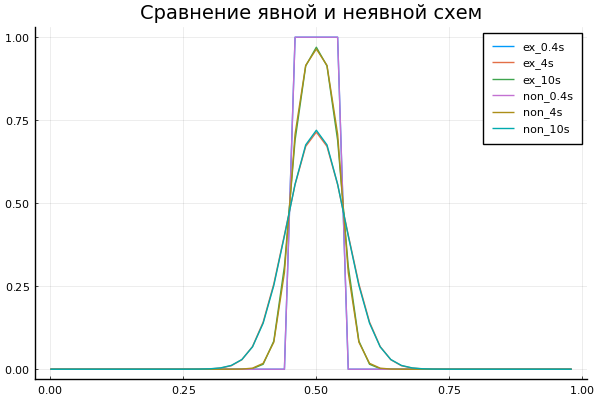

In [4]:
function nonexplicit(Nx = 50, Nt = 40; tlmt = 0.01)
    dx = 1/Nx
    dt = tlmt/Nt
    k = dt/(dx*dx)

    x = [i for i in range(0, length = Nx, step = dx)]
    t = [i for i in range(0, length = Nt, step = dt)]
    U = zeros(Nx, Nt)
    η = zeros(Nx+1)
    ξ = zeros(Nx)

    U[: ,1] = startcond.(x)
    U[1 ,:] = bordrcond.(t)
    U[Nt,:] = bordrcond.(t)

    for j = 1:Nt-1
        b = -1 - 2k*D( U[1,j] )
        c = -k*D( U[2,j] )
        d = U[1,j]
        ξ[2] = c/b
        η[2] = -d/b

        for i = 2:Nx-1

            a = -k*D( U[i-1,j] )
            b = -2k*D( U[i,j] ) - 1
            c = -k*D( U[i+1,j] )
            d = U[i,j]

            ξ[i+1] = c / (b-a*ξ[i])
            η[i+1] = (a*η[i]-d) / (b-a*ξ[i])
        end

        U[Nx,j+1] = η[Nx]

        for i = Nx:-1:2
            U[i-1,j+1] = ξ[i]*U[i,j+1] + η[i]
        end
    end
    t, x, U
end

t1, X1, Ans3 = nonexplicit( tlmt = 10)

plot(X, Ans2[:,1], lab = "ex_0.4s")
plot!(X, Ans2[:,40], lab = "ex_4s")
plot!(X, Ans2[:,10], lab = "ex_10s")
plot!(1X, Ans3[:,1], lab = "non_0.4s")
plot!(X1, Ans3[:,10], lab = "non_4s")
p1 = plot!(X1, Ans3[:,40], lab = "non_10s", title = "Сравнение явной и неявной схем")

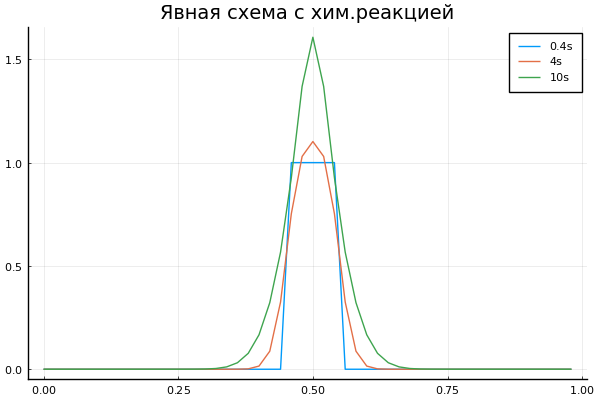

In [5]:
ΔN(u, n, t) = (-n/τ(n)) * exp(-E/u) * t
E = 3
τ(n) = 1

t, X, Ans4, N = linexplicit( tlmt = 10 )

plot(X, Ans4[:,1], lab = "0.4s")
plot!(X, Ans4[:,10], lab = "4s")
p = plot!(X, Ans4[:,40], lab = "10s", title = "Явная схема с хим.реакцией")

И остается вопрос, с тем как задать аналитическое решение, так как неизвестно какое брать $Q_0$ и $Q$

In [25]:
function linexplicit2D(Nx = 50, Ny = 50, Nt = 40; tlmt = 0.1)
    dx = 1/Nx
    dy = 1/Ny
    dt = tlmt/Nt
    r = dt/(dx*dx)

    x = [i for i in range(0, length = Nx, step = dx)] 
    t = [i for i in range(0, length = Nt, step = dt)] 
    U = zeros(Nx, Ny, Nt)
    N = zeros(Nx, Nt)
    
    N[:, 1] = startcond_N.(x)
    
   
    U[:,:,1] .= 1
    U[1,1,:] = U[Nt,Nt,:] .= 0
    

    for j = 1:Nt-1, i = 2:Nx-1, k = 2:Ny - 1
        U[i, k, j+1] = U[i,k,j]*(1-2*r*D( U[i,k,j])) + r*U[i-1,k,j]*D( U[i-1,k,j] ) + r*U[i+1,k,j]*D( U[i+1,k,j])  +r*U[i,k-1,j]*D( U[i,k-1,j] ) + r*U[i,k+1,j]*D( U[i,k+1,j]) - ΔN(U[i, k, j], N[i, j], dt)
        N[i, j+1] = N[i, j] - ΔN(U[i, k, j], N[i, j], dt)
    end
    t, x, U
end

t5, X5, Ans5 = linexplicit2D(tlmt = 10)

using PyPlot
surf(t5, X5, Ans5[:,:,1])
    

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/dimashestakov/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (50, 40) and arg 2 with shape (50, 50).')
  File "/Users/dimashestakov/.julia/conda/3/x86_64/lib/python3.10/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 1389, in plot_surface
    X, Y, Z = np.broadcast_arrays(X, Y, Z)
  File "<__array_function__ internals>", line 200, in broadcast_arrays
  File "/Users/dimashestakov/.julia/conda/3/x86_64/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 540, in broadcast_arrays
    shape = _broadcast_shape(*args)
  File "/Users/dimashestakov/.julia/conda/3/x86_64/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 422, in _broadcast_shape
    b = np.broadcast(*args[:32])
